<a href="https://colab.research.google.com/github/macwolfz/DZDeepLearningCancerClassification/blob/main/ModeloKerasLabCollab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf

In [18]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [19]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [20]:
import os
import glob
import pathlib
#from shutil import copyfile
import shutil
from sys import exit
import matplotlib.pyplot as plt
from shutil import copyfile
#import keras.backend.tensorflow_backend as tfback

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [22]:
import pydotplus
import graphviz

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
num_skipped = 0
for folder_name in ("cancer", "no_cancer"):
    folder_path = os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)
#

Deleted 0 images


In [24]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Collab Notebooks/LungCells",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Collab Notebooks/LungCells",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 3318 files belonging to 2 classes.
Using 2655 files for training.
Found 3318 files belonging to 2 classes.
Using 663 files for validation.


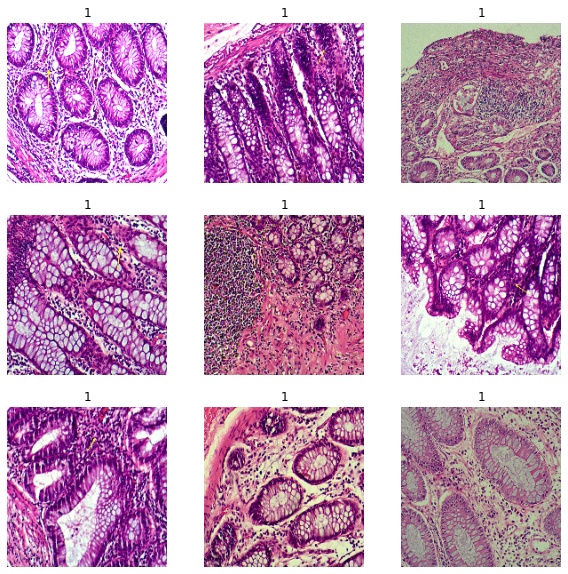

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [27]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

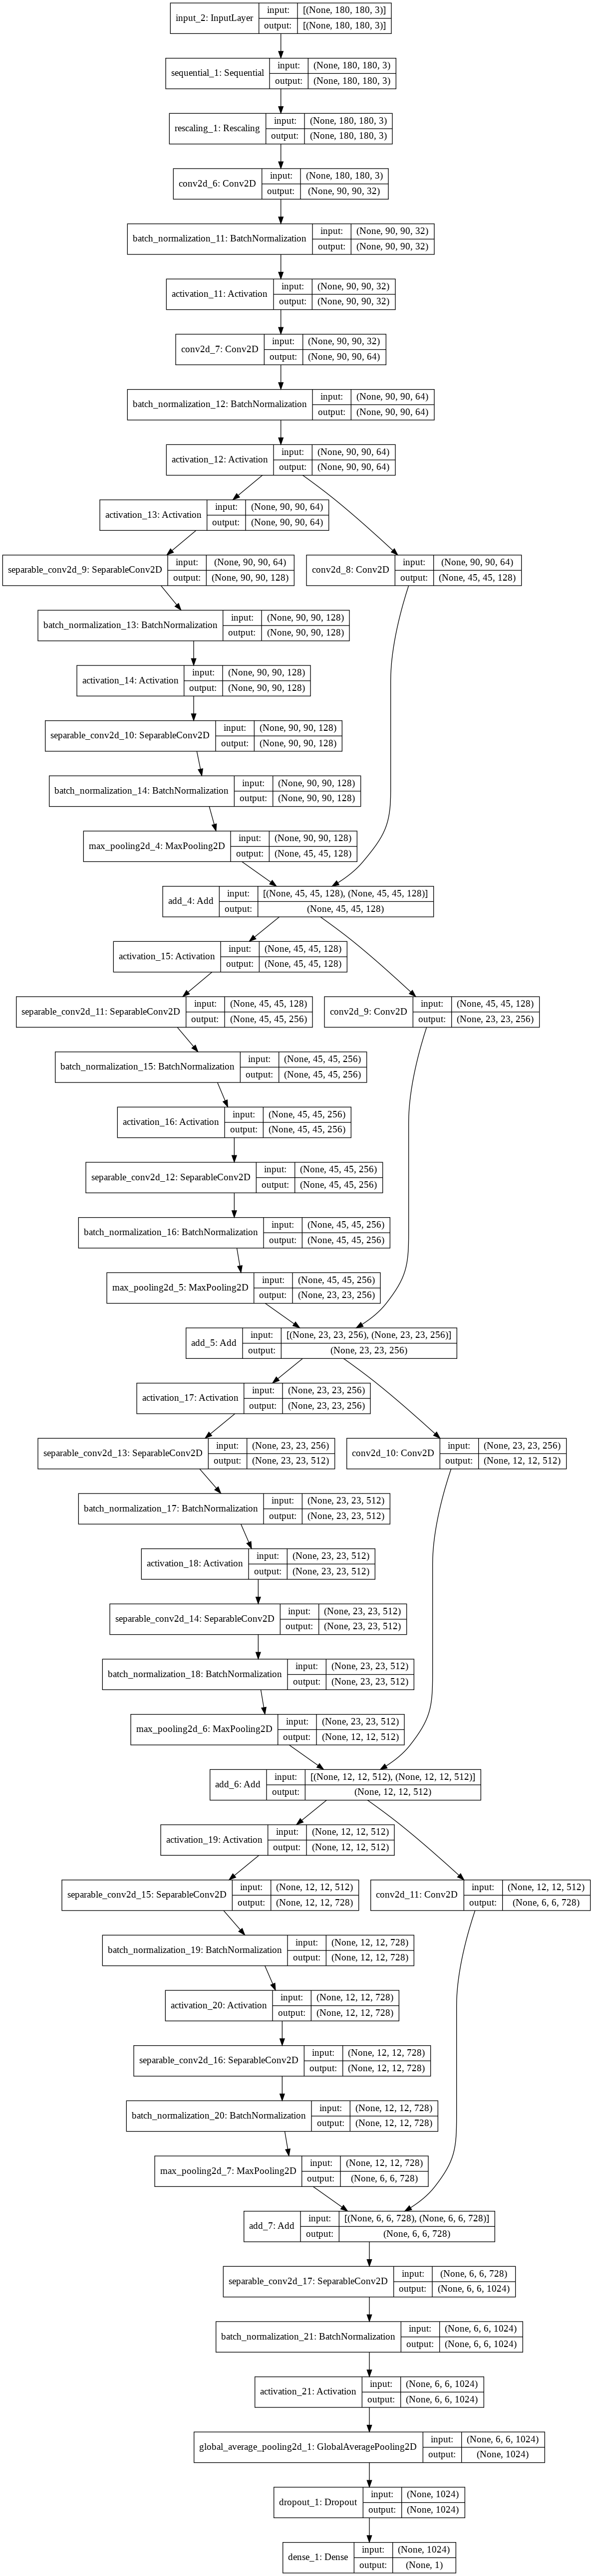

In [28]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [29]:
epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
83/83 [==============================] - 506s 6s/step - loss: 0.1466 - accuracy: 0.9172 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 2/50
83/83 [==============================] - 54s 603ms/step - loss: 4.1712e-04 - accuracy: 1.0000 - val_loss: 1.2218e-04 - val_accuracy: 1.0000
Epoch 3/50
83/83 [==============================] - 53s 590ms/step - loss: 2.5380e-04 - accuracy: 1.0000 - val_loss: 1.7389e-06 - val_accuracy: 1.0000
Epoch 4/50
83/83 [==============================] - 52s 588ms/step - loss: 1.8021e-04 - accuracy: 1.0000 - val_loss: 1.2473e-07 - val_accuracy: 1.0000
Epoch 5/50
83/83 [==============================] - 53s 593ms/step - loss: 1.3812e-04 - accuracy: 1.0000 - val_loss: 1.4235e-07 - val_accuracy: 1.0000
Epoch 6/50
83/83 [==============================] - 53s 593ms/step - loss: 1.0881e-04 - accuracy: 1.0000 - val_loss: 3.7829e-06 - val_accuracy: 1.0000
Epoch 7/50
83/83 [==============================] - 52s 590ms/step - loss: 9.2204e-05 - accuracy: 1.0000

In [30]:
img = keras.preprocessing.image.load_img(
    "seg_pred/seg_pred/46_non_cancer_test.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Cancer and %.2f percent No Cancer."
    % (100 * (1 - score), 100 * score)
)

FileNotFoundError: ignored